In [ ]:
pip install mne mne_icalabel autoreject

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 27.3 MB/s eta 0:00:00


In [ ]:
import mne
import numpy as np
import os
import matplotlib.pyplot as plt
from mne.preprocessing import ICA
from mne.time_frequency import tfr_multitaper
from mne_icalabel import label_components
from mne import pick_types
from mne.preprocessing import find_bad_channels_maxwell
from autoreject import AutoReject
import scipy.signal as signal
from ipywidgets import interact, FloatSlider

In [ ]:
# Create a directory to store the data
!mkdir -p /content/eeg_data

# Download the dataset into the new directory

!wget -r -N -c -np https://physionet.org/files/ltrsvp/1.0.0/10-Hz/rsvp_10Hz_02a.edf
!wget -r -N -c -np https://physionet.org/files/ltrsvp/1.0.0/6-Hz/rsvp_6Hz_02a.edf
!wget -r -N -c -np https://physionet.org/files/ltrsvp/1.0.0/5-Hz/rsvp_5Hz_02a.edf

!wget -r -N -c -np https://physionet.org/files/ltrsvp/1.0.0/10-Hz/rsvp_10Hz_06a.edf


--2024-09-22 15:35:20--  https://physionet.org/files/ltrsvp/1.0.0/10-Hz/rsvp_10Hz_02a.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘physionet.org/files/ltrsvp/1.0.0/10-Hz/rsvp_10Hz_02a.edf’ not modified on server. Omitting download.

--2024-09-22 15:35:21--  https://physionet.org/files/ltrsvp/1.0.0/6-Hz/rsvp_6Hz_02a.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘physionet.org/files/ltrsvp/1.0.0/6-Hz/rsvp_6Hz_02a.edf’ not modified on server. Omitting download.

--2024-09-22 15:35:22--  https://physionet.org/files/ltrsvp/1.0.0/5-Hz/rsvp_5Hz_02a.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sen

In [ ]:
# List the contents of the eeg_data directory
#!ls physionet.org/files/ltrsvp/1.0.0/10-Hz/

index.html	   rsvp_10Hz_02b.edf  rsvp_10Hz_03b.edf  rsvp_10Hz_04b.edf  rsvp_10Hz_06b.edf
rsvp_10Hz_02a.edf  rsvp_10Hz_03a.edf  rsvp_10Hz_04a.edf  rsvp_10Hz_06a.edf


Extracting EDF parameters from /content/physionet.org/files/ltrsvp/1.0.0/10-Hz/rsvp_10Hz_02a.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 514047  =      0.000 ...   251.000 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: EEG PO8, EEG PO7, EEG P8, EEG P7, EEG O1, EEG O2, EEG PO3, EEG ...
 chs: 9 EEG
 custom_ref_applied: False
 highpass: 0.1 Hz
 lowpass: 28.0 Hz
 meas_date: 2013-02-06 23:27:16 UTC
 nchan: 9
 projs: []
 sfreq: 2048.0 Hz
 subject_info: 3 items (dict)
>


<ipython-input-31-626feeb2cbc1>:3: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  rsvp_10Hz_02a_raw = mne.io.read_raw_edf(rsvp_10Hz_02a_edf, preload=True)
<ipython-input-31-626feeb2cbc1>:3: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  rsvp_10Hz_02a_raw = mne.io.read_raw_edf(rsvp_10Hz_02a_edf, preload=True)


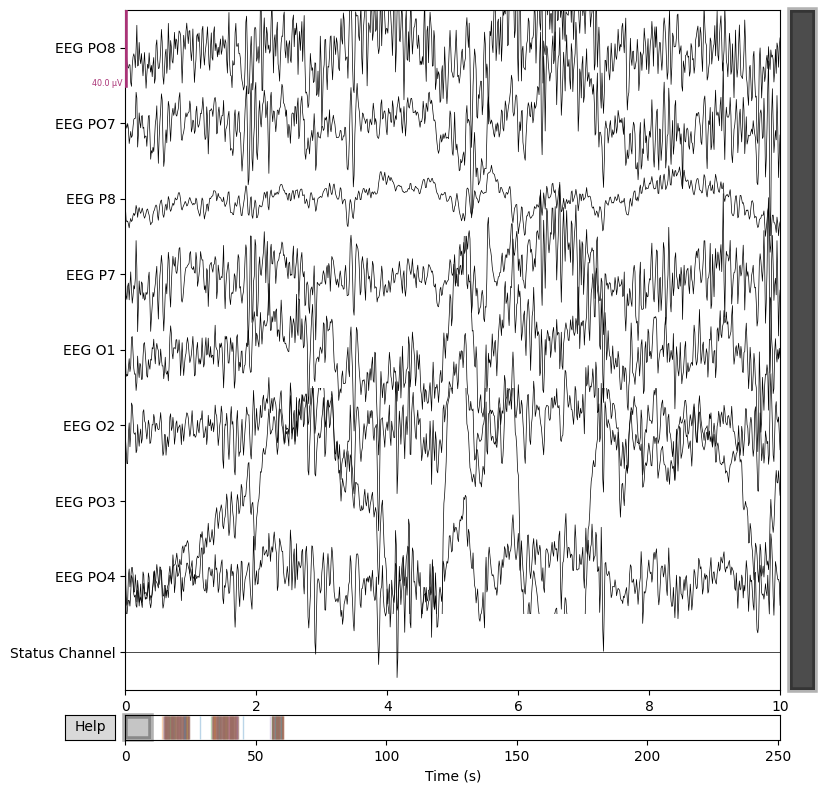

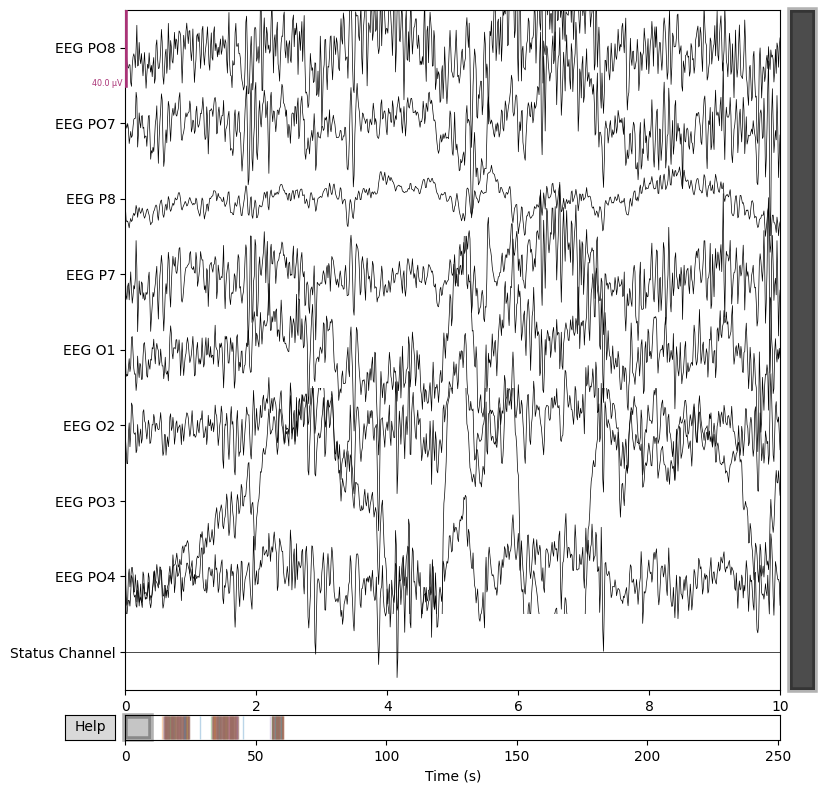

In [ ]:
# Load one of the EDF files (e.g., S001R01.edf)
rsvp_10Hz_02a_edf = 'physionet.org/files/ltrsvp/1.0.0/10-Hz/rsvp_10Hz_02a.edf'
rsvp_10Hz_02a_raw = mne.io.read_raw_edf(rsvp_10Hz_02a_edf, preload=True)


# Check the available channel names
print(rsvp_10Hz_02a_raw.info)


# Define the reference channels
#ref_channels = ['EARL', 'EARR']

# Plot the raw EEG data
rsvp_10Hz_02a_raw.plot(n_channels=30, duration=10)

In [ ]:
import pandas as pd

# Convert annotations to a DataFrame
annotations = rsvp_10Hz_02a_raw.annotations
annotations_df = annotations.to_data_frame()

# Display the DataFrame
display(annotations_df)


,onset,duration,description
0,2013-02-06 23:27:30.103000,0.0,RSVP_burstSize=100_block=0_frame rate=6
1,2013-02-06 23:27:30.612300,0.0,"T=0,x=-1"
2,2013-02-06 23:27:30.716300,0.0,"T=0,x=-1"
3,2013-02-06 23:27:30.815400,0.0,"T=1,x=259"
4,2013-02-06 23:27:30.915500,0.0,"T=0,x=-1"
...,...,...,...
246,2013-02-06 23:28:16.163000,0.0,"T=0,x=-1"
247,2013-02-06 23:28:16.263600,0.0,"T=1,x=366"
248,2013-02-06 23:28:16.363200,0.0,"T=0,x=-1"
249,2013-02-06 23:28:16.462800,0.0,"T=0,x=-1"


In [ ]:
# Load one of the EDF files (e.g., S001R01.edf)
edf_fileb = 'physionet.org/files/ltrsvp/1.0.0/10-Hz/rsvp_10Hz_02b.edf'
raw_datab = mne.io.read_raw_edf(edf_fileb, preload=True)


# Check the available channel names
print(raw_datab.info)


# Define the reference channels
#ref_channels = ['EARL', 'EARR']

# Plot the raw EEG data
raw_datab.plot(n_channels=30, duration=10)

# Convert annotations to a DataFrame
annotationsb = raw_datab.annotations
annotationsb_df = annotationsb.to_data_frame()

# Display the DataFrame
display(annotationsb_df)

Extracting EDF parameters from /content/physionet.org/files/ltrsvp/1.0.0/10-Hz/rsvp_10Hz_02b.edf...
EDF file detected


FileNotFoundError: [Errno 2] No such file or directory: '/content/physionet.org/files/ltrsvp/1.0.0/10-Hz/rsvp_10Hz_02b.edf'

Not setting metadata
246 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 246 events and 1230 original time points ...
0 bad epochs dropped


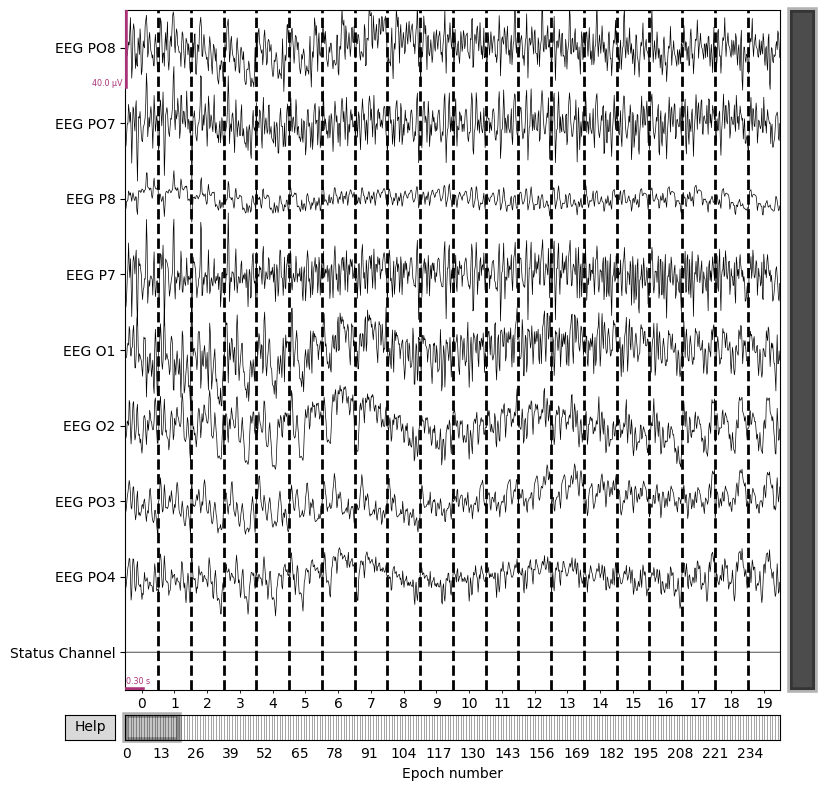

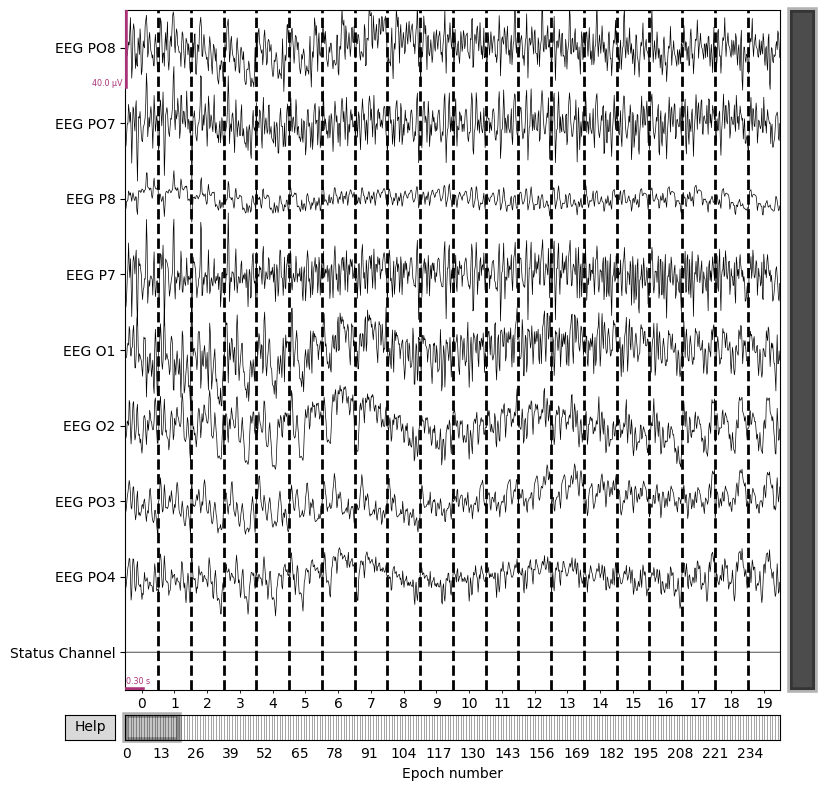

Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


<ipython-input-33-658dacc56f37>:2: UserWarning: Zero value in spectrum for channel Status Channel
  psd = rsvp_10Hz_02a_raw.compute_psd(fmax=70)  # Compute PSD for frequencies up to 50 Hz
<ipython-input-33-658dacc56f37>:5: UserWarning: Infinite value in PSD for channel Status Channel.
These channels might be dead.
  psd.plot()
<ipython-input-33-658dacc56f37>:5: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd.plot()


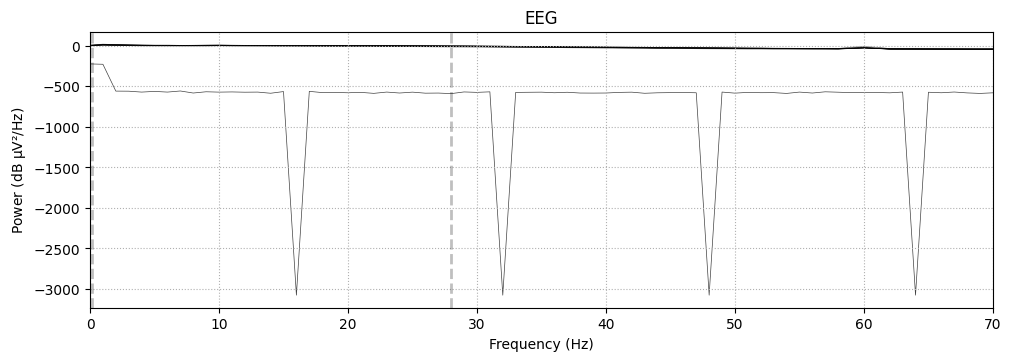

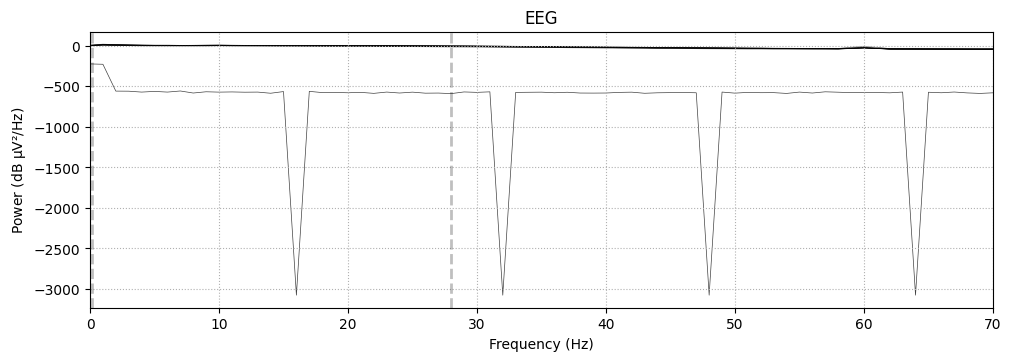

In [ ]:
# Compute the Power Spectral Density (PSD)
psd = rsvp_10Hz_02a_raw.compute_psd(fmax=70)  # Compute PSD for frequencies up to 50 Hz

# Plot the PSD
psd.plot()

Original Sampling Frequency: 2048.0 Hz
Downsampled Sampling Frequency: 64 Hz


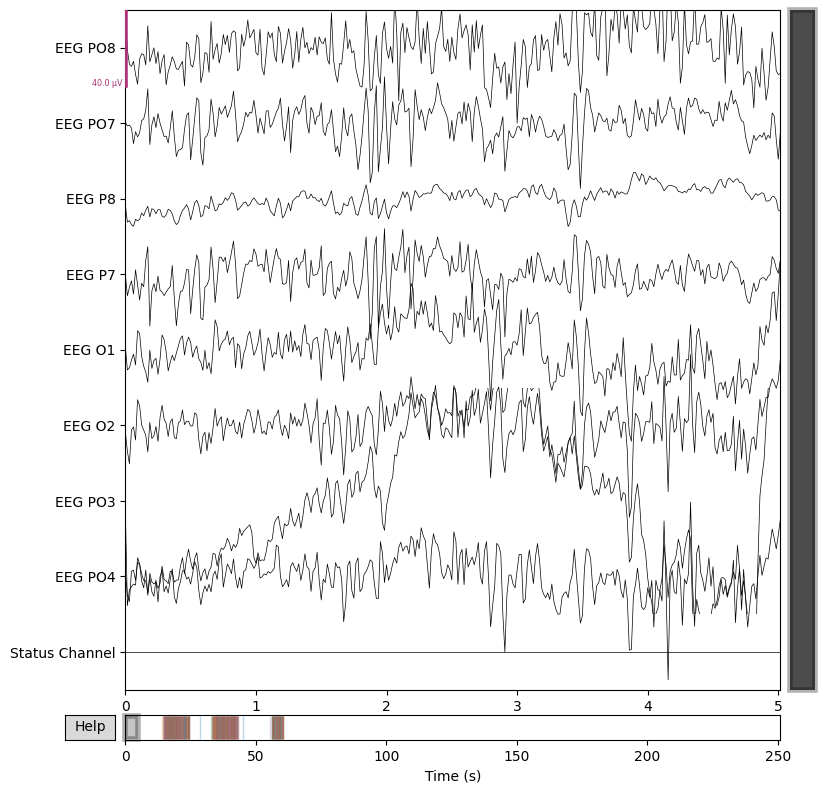

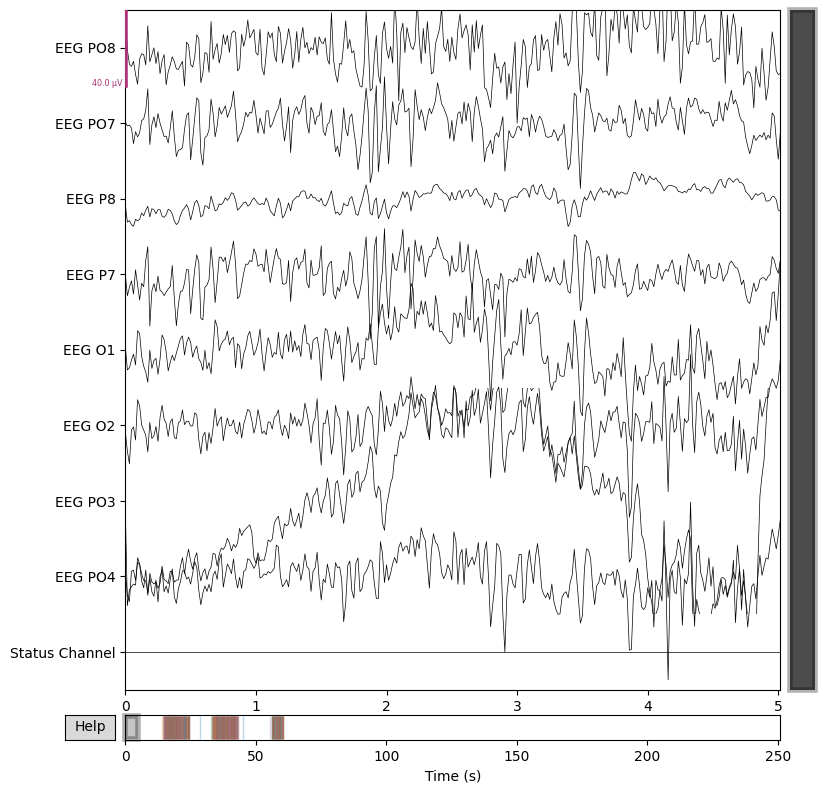

In [ ]:
# Get the original sampling rate
original_sfreq = rsvp_10Hz_02a_raw.info['sfreq']
print(f"Original Sampling Frequency: {original_sfreq} Hz")

# Downsample the data (below the Nyquist rate)
# For example, if the original sampling rate is 160 Hz, we downsample to 40 Hz.
# This will cause aliasing for frequencies above 20 Hz (Nyquist frequency = 20 Hz)

downsampled_sfreq = 64  # New downsampled frequency below the Nyquist limit
raw_data_downsampled = rsvp_10Hz_02a_raw.copy().resample(downsampled_sfreq)

# Print basic information after downsampling
print(f"Downsampled Sampling Frequency: {downsampled_sfreq} Hz")

# Plot the downsampled EEG data (aliased signal)
raw_data_downsampled.plot(duration=5)

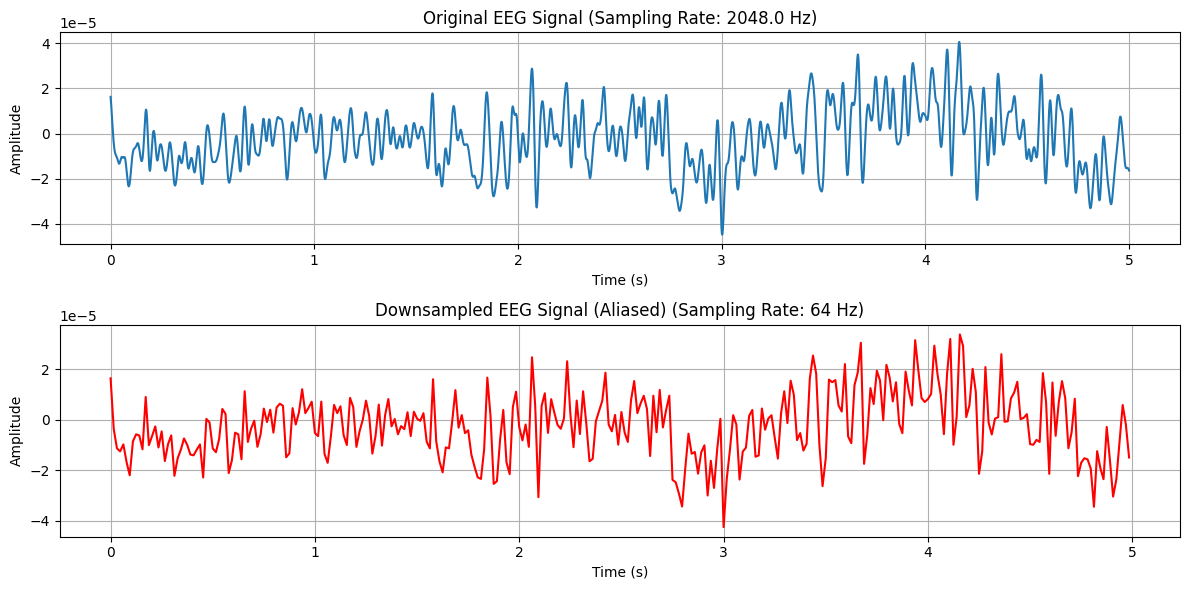

In [ ]:
# Extract a few seconds of data from both the original and downsampled datasets
# Ensure that the indices are integers by converting the sampling frequency to an integer
n_channels = 8  # Number of channels to extract
duration = 5  # Duration in seconds

# Convert the durations to integer samples
n_samples_original = int(duration * original_sfreq)  # Number of samples for the original data
n_samples_downsampled = int(duration * downsampled_sfreq)  # Number of samples for the downsampled data

# Extract data from both datasets
original_data, times = rsvp_10Hz_02a_raw[:n_channels, :n_samples_original]
downsampled_data, times_downsampled = raw_data_downsampled[:n_channels, :n_samples_downsampled]

# Plot the original vs. downsampled data for a single channel (e.g., channel 1)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot original data
plt.subplot(2, 1, 1)
plt.plot(times, original_data[0], label='Original Signal')
plt.title(f'Original EEG Signal (Sampling Rate: {original_sfreq} Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

# Plot downsampled data
plt.subplot(2, 1, 2)
plt.plot(times_downsampled, downsampled_data[0], label='Downsampled Signal (Aliased)', color='r')
plt.title(f'Downsampled EEG Signal (Aliased) (Sampling Rate: {downsampled_sfreq} Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

## ERP Target vs. Non-Target


Not setting metadata
246 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 246 events and 1230 original time points ...
0 bad epochs dropped


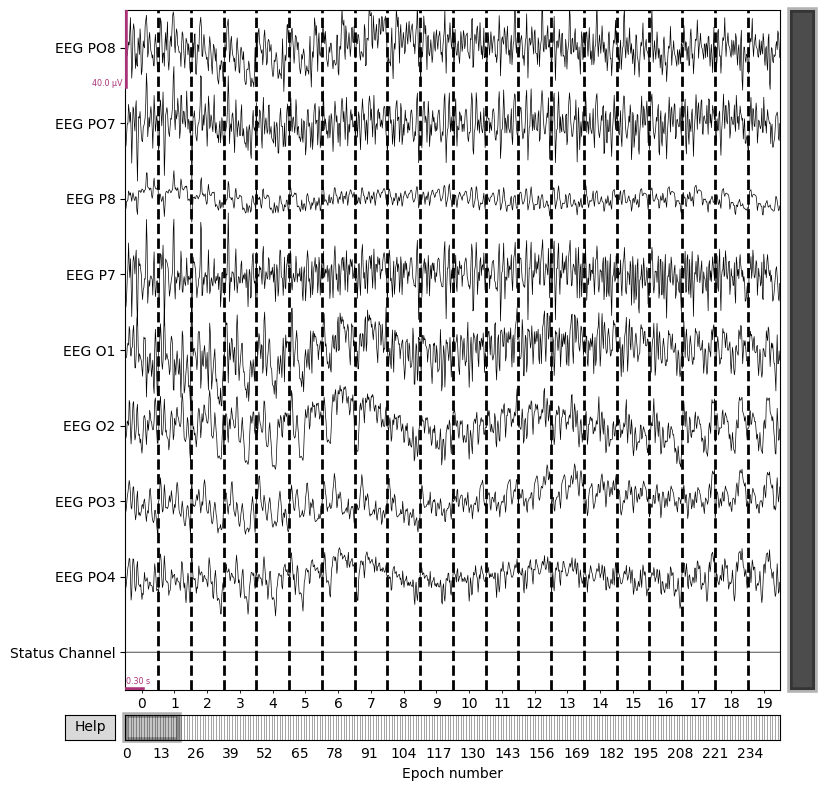

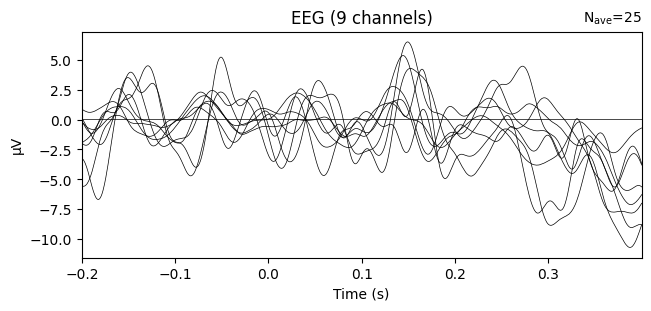

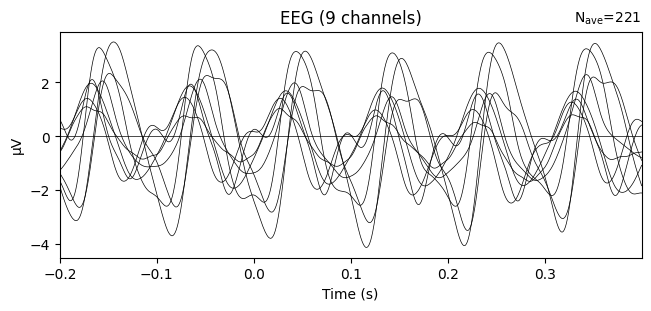

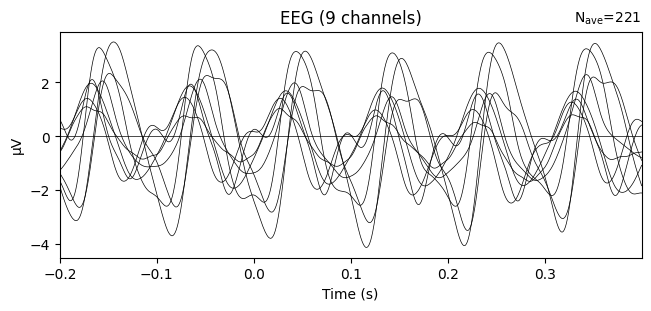

In [ ]:
# Initialize lists to store event onset times and event IDs
event_times = []
event_ids = []

# Parse annotations to create events
for i, desc in enumerate(annotations.description):
    onset = annotations.onset[i]

    # Check for target (T=1) or distractor (T=0)
    if 'T=1' in desc:
        event_times.append(onset)
        event_ids.append(1)  # 1 for target
    elif 'T=0' in desc:
        event_times.append(onset)
        event_ids.append(0)  # 0 for distractor

# Create the events array required by MNE
events = np.array([np.array([int(time * rsvp_10Hz_02a_raw.info['sfreq']), 0, event_id]) for time, event_id in zip(event_times, event_ids)])

# Define event_id dictionary for MNE
event_id = {'target': 1, 'distractor': 0}

# Define the epoching parameters
tmin = -0.2  # Start -200ms before the event
tmax = 0.4  # End 400ms after the event
baseline = (-0.2, 0)  # Baseline is the mean of the 200ms interval preceding the stimulus onset

# Epoch the data with baseline correction
epochs = mne.Epochs(rsvp_10Hz_02a_raw, events, event_id, tmin, tmax, baseline=baseline, preload=True)

# Plot the epochs
epochs.plot()

epochs['target'].average().plot()
epochs['distractor'].average().plot()


## ERP of target stimuli at PO7 and PO8

Need more than one channel to make topography for eeg. Disabling interactivity.
Need more than one channel to make topography for eeg. Disabling interactivity.


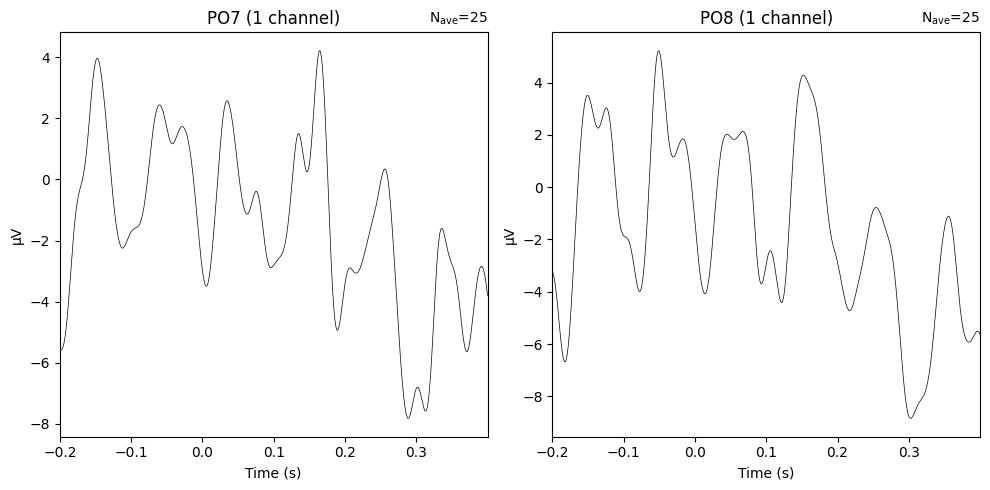

In [ ]:
# Extract the ERPs for PO7 and PO8
po7_evoked = epochs['target'].average(picks='EEG PO7')
po8_evoked = epochs['target'].average(picks='EEG PO8')

# Plot the ERPs
plt.figure(figsize=(10, 5))

# Plot PO7
plt.subplot(1, 2, 1)
po7_evoked.plot(axes=plt.gca(), show=False, spatial_colors=False, titles='PO7')

# Plot PO8
plt.subplot(1, 2, 2)
po8_evoked.plot(axes=plt.gca(), show=False, spatial_colors=False, titles='PO8')

plt.tight_layout()
plt.show()

## ERP left vs. right lateralized targets

In [ ]:
# Define constants
center_pixel = 320  # Center of the image in pixels
pixel_threshold = 67  # Pixel equivalent of ±1.2° of visual angle

# Load the EDF file
edf_file = 'physionet.org/files/ltrsvp/1.0.0/10-Hz/rsvp_10Hz_03a.edf'
raw = mne.io.read_raw_edf(edf_file, preload=True)

# Extract annotations
annotations = raw.annotations

# Identify lateral target epochs based on visual angle `x`
left_targets = []
right_targets = []

print(annotations.description)

for i, desc in enumerate(annotations.description):
    onset = annotations.onset[i]
    if 'T=1' in desc:  # Only consider targets
        #print(desc)
        # Extract the value of x by splitting the string
        x_value = desc.split('x=')[1]

        # Convert x_value to an integer
        x_value = int(x_value)

        if x_value < (center_pixel - pixel_threshold):
          left_targets.append(onset)
          #print("left", desc)
        elif x_value > (center_pixel + pixel_threshold):
          right_targets.append(onset)
          #print("right", desc)

# Create events array
left_events = np.array([np.array([int(time * raw.info['sfreq']), 0, 1]) for time in left_targets])
right_events = np.array([np.array([int(time * raw.info['sfreq']), 0, 2]) for time in right_targets])
events = np.vstack([left_events, right_events])


# Define event_id for MNE
event_id = {'left_target': 1, 'right_target': 2}




Extracting EDF parameters from /content/physionet.org/files/ltrsvp/1.0.0/10-Hz/rsvp_10Hz_03a.edf...
EDF file detected


FileNotFoundError: [Errno 2] No such file or directory: '/content/physionet.org/files/ltrsvp/1.0.0/10-Hz/rsvp_10Hz_03a.edf'

Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 14 events and 1230 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<ipython-input-27-c77db7c9789f>:7: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=baseline, preload=True)


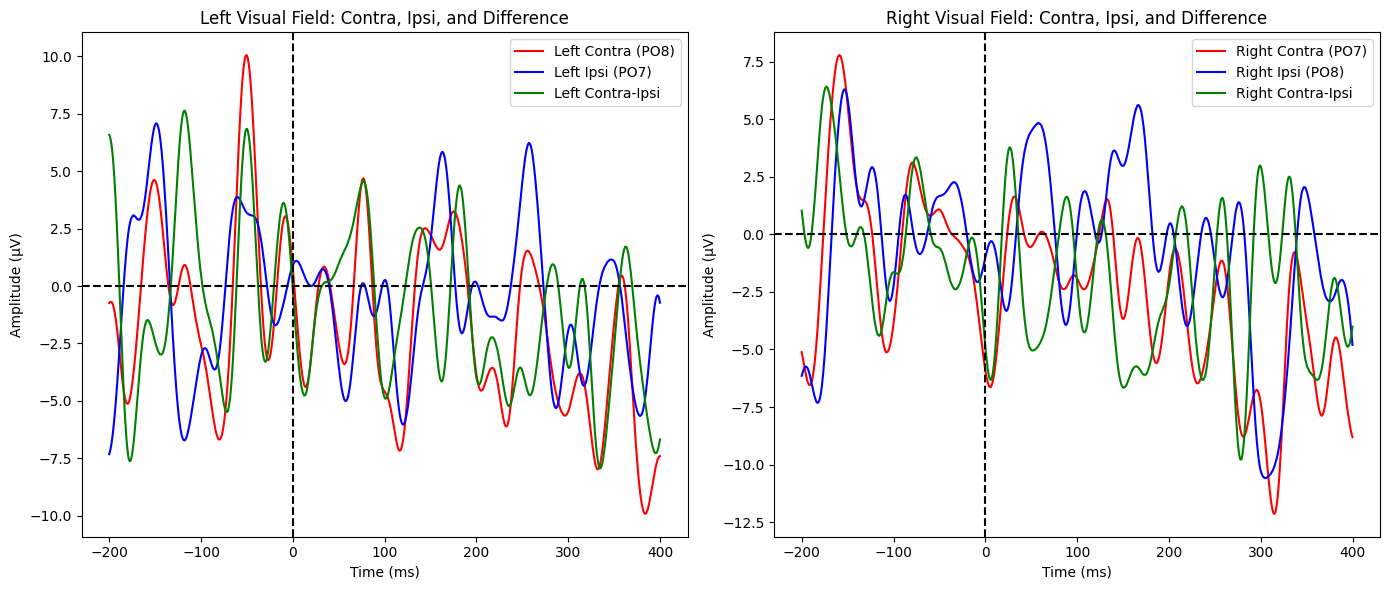

In [ ]:
# Define epoching parameters
tmin = -0.2  # 200 ms before stimulus
tmax = 0.4  # 400 ms after stimulus
baseline = (-0.2, 0)  # Baseline from -200 ms to 0 ms

# Epoch data
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=baseline, preload=True)

# Separate the epochs based on visual field
left_epochs = epochs['left_target']
right_epochs = epochs['right_target']

# Calculate the evoked responses
left_evoked = left_epochs.average()
right_evoked = right_epochs.average()

# Extract data from PO7 and PO8 electrodes
left_contra = left_evoked.copy().pick_channels(['EEG PO8']).data[0] # remove
left_ipsi = left_evoked.copy().pick_channels(['EEG PO7']).data[0] # remove
right_contra = right_evoked.copy().pick_channels(['EEG PO7']).data[0]
right_ipsi = right_evoked.copy().pick_channels(['EEG PO8']).data[0]

# Calculate the difference waveforms (contralateral minus ipsilateral)
left_diff = left_contra - left_ipsi
right_diff = right_contra - right_ipsi

# Average the differences for plotting
avg_diff = (left_diff + right_diff) / 2

times = left_evoked.times * 1000  # Convert time to milliseconds
# Plotting the ERP waveforms
plt.figure(figsize=(14, 6))

# Left visual field subplot
plt.subplot(1, 2, 1)
plt.plot(times, left_contra * 1e6, label='Left Contra (PO8)', color='r')
plt.plot(times, left_ipsi * 1e6, label='Left Ipsi (PO7)', color='b')
plt.plot(times, left_diff * 1e6, label='Left Contra-Ipsi', color='g')
plt.axvline(x=0, color='black', linestyle='--')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (µV)')
plt.title('Left Visual Field: Contra, Ipsi, and Difference')
plt.legend()

# Right visual field subplot
plt.subplot(1, 2, 2)
plt.plot(times, right_contra * 1e6, label='Right Contra (PO7)', color='r')
plt.plot(times, right_ipsi * 1e6, label='Right Ipsi (PO8)', color='b')
plt.plot(times, right_diff * 1e6, label='Right Contra-Ipsi', color='g')
plt.axvline(x=0, color='black', linestyle='--')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (µV)')
plt.title('Right Visual Field: Contra, Ipsi, and Difference')
plt.legend()

plt.tight_layout()
plt.show()
